Import Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import subprocess
import time
import os

from scipy.spatial import cKDTree
from fastprogress.fastprogress import progress_bar
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib import ticker


Create Necessary Functions

In [ ]:
class Gelu(nn.Module):
    """Implements GELU as an activation Function """
    def __init__(self):
        super().__init__()
        self.gelu = nn.GELU()

    def forward(self, x):
        """Applies GELU Activation to input tensor"""
        return self.gelu(x)
    
class tanh(nn.Module):
    """Implements Tanh as an activation Function """
    def __init__(self):
        super().__init__()
        self.tanh = nn.Tanh()

    def forward(self, x):
        """Applies tanh Activation to input tensor"""
        return self.tanh(x)

class EarlyStopping:
    """Implements EarlyStopping Method to avoid overfitting and resource waste"""
    def __init__(self, patience=5000, min_delta=0.0):
        """
        Args:
            patience (int): Max. step number with no progress
            min_delta (float): Min. progress to update counter
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, current_loss):
        if self.best_loss is None:
            self.best_loss = current_loss

        elif self.best_loss - current_loss > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0

        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def build_model(n_inputs, n_outputs, n_hlayers, n_neurons, act_func):
    """
    Creates fully connected NN with XAVIER inicialization.
    
    Args:
        n_inputs: Input layer Neurons
        n_outputs: Output Layer Neurons
        n_hlayers: Hidden Layers
        n_neurons: Neurons Per Hidden Layer
        act_func: Activation Function
    
    Returns:
        Fully connected NN
    """
    layers = []

    layers.append(nn.Linear(n_inputs, n_neurons))       # Input layer
    nn.init.xavier_uniform_(layers[-1].weight)  # Inicialización Xavier
    nn.init.zeros_(layers[-1].bias)
    layers.append(act_func())

    for _ in range(n_hlayers):                          # Hidden layer
        layers.append(nn.Linear(n_neurons, n_neurons))
        nn.init.xavier_uniform_(layers[-1].weight)  # Inicialización Xavier
        nn.init.zeros_(layers[-1].bias)
        layers.append(act_func())

    layers.append(nn.Linear(n_neurons, n_outputs))      # Output layer

    model = nn.Sequential(*layers)

    return model

def Grads(y, x, idx=None):
    """
    Computes the gradient of the input tensor.
    
    Args:
        y: Desired grads tensor
        x: Reference tensor to obtain grads
        idx: if none both grads are return, if 0 or 1 only one of them is return
        
    Returns:
        Grads in the desired axis"""
    outputs = torch.ones_like(y)
    grads, = torch.autograd.grad(y, 
                                 x, 
                                 grad_outputs=outputs, 
                                 create_graph=True)
    
    return grads if idx is None else grads[:, idx]

def sample(xmin, xmax, ymin, ymax , n_sample, device='cuda'):
    """Function to sample a given 2D domain enclosed in the max and min values.
    
    Args:
        xmin: Min x value of the domain
        xmax: Max x value of the domain
        ymin: Min y value of the domain
        ymax: Max y value of the domain
        n_sample: Number of points to sample
        device='cuda': Device to create the tensor in
    
    Returns:
        Sampled (n_sample,2) tensor in specified device
    """
    x = xmin + (xmax - xmin) * torch.rand(n_sample, device=device)
    y = ymin + (ymax - ymin) * torch.rand(n_sample, device=device)
    return torch.stack([x, y], dim=-1)

def bound_sample(xmin, xmax, ymin, ymax, b_sample, device='cuda'):
    """Function to sample a given 2D domain boundaries.
    
    Args:
        xmin: Min x value of the domain
        xmax: Max x value of the domain
        ymin: Min y value of the domain
        ymax: Max y value of the domain
        b_sample: Number of points to sample in EACH boundary
        device='cuda': Device to create the tensor in
    
    Returns:
        lbound: (b_sample, 2) tensor for the left boundary
        rbound: (b_sample, 2) tensor for the right boundary
        bbound: (b_sample, 2) tensor for the bottom boundary
        tbound: (b_sample, 2) tensor for the top boundary
    """
    y_left = ymin + (ymax - ymin) * torch.rand(b_sample, device=device)
    x_left = torch.full((b_sample,), xmin, device=device)
    lbound = torch.stack([x_left, y_left], dim=-1)

    y_right = ymin + (ymax - ymin) * torch.rand(b_sample, device=device)
    x_right = torch.full((b_sample,), xmax, device=device)
    rbound = torch.stack([x_right, y_right], dim=-1)

    x_bottom = xmin + (xmax - xmin) * torch.rand(b_sample, device=device)
    y_bottom = torch.full((b_sample,), ymin, device=device)
    bbound = torch.stack([x_bottom, y_bottom], dim=-1)

    x_top = xmin + (xmax - xmin) * torch.rand(b_sample, device=device)
    y_top = torch.full((b_sample,), ymax, device=device)
    tbound = torch.stack([x_top, y_top], dim=-1)

    return lbound, rbound, bbound, tbound

def run_model(model_run, b_sample, domain_size_x, domain_size_y, device='cuda'):
    """Runs trained model.
    
    Args:
        model_run: Trained Model to use for prediction
        b_sample: Number of samples for the prediction grid
        domain_size_x: X size of the domain
        domain_size_y: Y size of the domain
        device='cuda'

    Returns:
        Predicted u, v, p values as a (b_sample, b_sample) tensor in "device"    
    """
    x = np.linspace(0, domain_size_x, b_sample)
    y = np.linspace(0 , domain_size_y, b_sample)
    X = np.stack(np.meshgrid(x, y), -1).reshape(-1, 2)
    X = torch.from_numpy(X).float().to(device=device)
    X.requires_grad_(True)

    model_run.eval()
    pred = model_run(X)  

    V_pred = Grads(pred[:,0], X)
    v, u = -V_pred[:,0], V_pred[:,1]

    p = pred[:,1]

    return u.reshape(b_sample, b_sample), v.reshape(b_sample, b_sample), p.reshape(b_sample,b_sample), x, y

def compute_normals(xy):
    """
    Computes unitary normals for a given array.

    Args:
        xy: Input array

    Returns:
        unit_normals: Unitary normals
    
    """
    xy_padded = np.vstack([xy[-1], xy, xy[0]])
    
    dx = xy_padded[2:, 0] - xy_padded[:-2, 0]
    dy = xy_padded[2:, 1] - xy_padded[:-2, 1]
    tangents = np.stack([dx, dy], axis=1)

    normals = np.stack([-tangents[:, 1], tangents[:, 0]], axis=1)

    norms = np.linalg.norm(normals, axis=1, keepdims=True)
    unit_normals = normals / norms

    return unit_normals

def NACAGen(naca, n, c, lead_edge):
    """
    Creates NACA airfoil array

    Args:
        naca: 4 or 5 digit int number
        n: Number of collocation points to create the airfoil
        c: Chord lenght of the airfoil
        lead_edge: Location of the leading edge of the airfoil

    Returns:
        x_coords: (n,1) array containing the X position of the airfoil points
        y_coords: (n,1) array containing the y position of the airfoil points 
    """
    x = np.linspace(0, c, n, endpoint=True)
    
    yc = np.zeros(n)
    dyc_dx = np.zeros(n)

    a0 = 0.2969
    a1 = -0.1260
    a2 = -0.3516
    a3 = 0.2843
    a4 = -0.1015
    
    if len(naca) == 4:
        # 4 Digit NACA generator --> N:100*m A:10*p CA:100*thickness
        m = int(naca[0])/100
        p = int(naca[1])/10
        th = int(naca[2] + naca[3])/100

        yt = 5*th*(a0*np.sqrt(x/c) + a1*(x/c) + a2*(x/c)**2 + a3*(x/c)**3 + a4*(x/c)**4)

        if p == 0:
            xU = x
            xL = x
            yU = yt
            yL = -yt
            airfoil_x = np.hstack((xU, xL))
            airfoil_y = np.hstack((yU, yL))
            return airfoil_x, airfoil_y
        else:
            x /= c
            for i in range(0, n):
                if x[i] <= p:
                    yc[i] = m/p**2 * (2*p*x[i] - x[i]**2)
                    dyc_dx[i] = m/p**2 * 2*(p - x[i])
                elif p<= x[i]:
                    yc[i] = m/(1-p)**2 * ((1-2*p) + 2*p*x[i] - x[i]**2)
                    dyc_dx[i] = m/(1-p)**2 * (2*p - 2*x[i])
            
            theta = np.arctan(dyc_dx)

            xU = x - yt*np.sin(theta)
            xL = x + yt*np.sin(theta)
            yU = yc + yt*np.cos(theta)
            yL = yc - yt*np.cos(theta)
            


            x_coords = np.hstack((xU[::-1], xL))
            y_coords = np.hstack((yU[::-1], yL))
            
            return x_coords*c + lead_edge[0], y_coords*c + lead_edge[1]
        
    elif len(naca) == 5:
        # 5 Digit NACA generator --> LPSTT
        l = int(naca[0]) * 0.15
        p = int(naca[1]) * 0.05
        s = int(naca[2])
        tt = int(naca[3] + naca[4])/100

        yt = 5*tt*(a0*np.sqrt(x/c) + a1*(x/c) + a2*(x/c)**2 + a3*(x/c)**3 + a4*(x/c)**4)

        if s == 0:
            if p==0.05:
                r =0.058
                k1 = 361.4
            elif p==0.1:
                r = 0.126
                k1 = 51.64
            elif p==0.15:
                r = 0.2025
                k1 = 15.957
            elif p==0.20:
                r = 0.29
                k1 = 6.643
            elif p==0.25:
                r = 0.391
                k1 = 3.23
            
            for i in range(0, n):
                if x[i] < r:
                    yc[i] = k1/6 * (x[i]**3 - 3*r*x[i]**2 + r**2*(3-r)*x[i])
                    dyc_dx[i] = k1/6 * (3*x[i]**2 - 6*r*x[i] + r**2*(3-r))
                else:
                    yc[i] = k1/6*r**3*(1-x[i])
                    dyc_dx[i] = -k1/6*r**3
        if s == 1:
            if p==0.1:
                r, k1, k2_1 = 0.13, 51.99, 0.000764
            elif p==0.15:
                r, k1, k2_1 = 0.217, 15.793, 0.00677
            elif p==0.20:
                r, k1, k2_1 = 0.318, 6.52, 0.303
            elif p==0.25:
                r, k1, k2_1 = 0.441, 3.191, 0.1355

            for i in range(0, n):
                if x[i] < r:
                    yc[i] = k1/6 * ( (x[i]/c-r)**3 - k2_1*(1-r)**3*x[i]/c - r**3*x[i]/c + r**3 )
                    dyc_dx[i] = k1/6 * (3*(x[i]/c-r)**2 - k2_1*(1-r)**3 - r**3)
                else:
                    yc[i] =  k1/6 * (k2_1*(x[i]/c-r)**3 - k2_1*(1-r)**3*x[i]/c - r**3*x[i]/c + r**3) 
                    dyc_dx[i] = k1/6 * (3*k2_1*(x[i]/c-r)**2 - k2_1*(1-r)**3 - r**3)

        theta = np.arctan(dyc_dx)

        xU = x - yt*np.sin(theta)
        xL = x + yt*np.sin(theta)
        yU = yc + yt*np.cos(theta)
        yL = yc - yt*np.cos(theta)

        x_coords = np.hstack((xU, xL))
        y_coords = np.hstack((yU, yL))
        coords  = np.hstack((x_coords.flatten(), y_coords.flatten()))
        
        slope = (y_coords[0,-1] - y_coords[0,0]) / (x_coords[0,-1] - x_coords[0,0])

        rot_angle = -np.arctan(slope)

        rot_mat = np.array([[np.cos(rot_angle), -np.sin(rot_angle)], 
                            [np.sin(rot_angle), np.cos(rot_angle)]])
        
        airfoil = np.dot(rot_mat, coords)

        return airfoil[0] + lead_edge[0], airfoil[1] + lead_edge[1]


Parameters Definition

In [3]:
domain_size_x = 5
domain_size_y = 2
n_sample = 50000
f_sample = 0
b_sample = 30000

# Physical
Uinf = 1
pinf = 101325
chord = 1
r0 = 1
din_vis = 5e-3
Re = Uinf*r0*chord/din_vis

print(Re)
din_p = 0.5*r0*Uinf**2 

# Model
n_inputs, n_outputs, n_hlayers, n_neurons, act_func = 2, 2, 4, 20, Gelu
device = torch.device('cuda')
af_model = build_model(n_inputs, n_outputs, n_hlayers, n_neurons, act_func)
af_model.to(device)

n_steps = 15000
optimizer = torch.optim.Adam(af_model.parameters(), lr=1e-2)
af_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 200, threshold=1e-2, min_lr=1e-7)
af_early_stopper = EarlyStopping(patience=500, min_delta=1e-3)
criterion = torch.nn.MSELoss()

# Airfoil
naca = '0012'
n_points = 1000

200.0


Domain Sampling

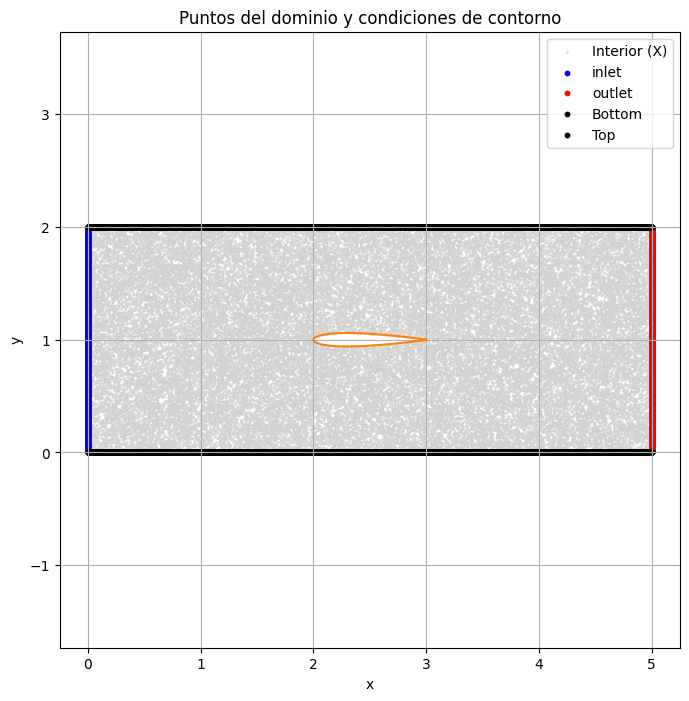

In [4]:
inlet, outlet, bot_wall, top_wall = bound_sample(0, domain_size_x, 0, domain_size_y, b_sample, device=device)

full_sample = sample(0, domain_size_x, 0, domain_size_y,  n_sample, device=device)

leading_edge = (2, domain_size_y/2)
naca_x, naca_y = NACAGen(naca, n_points, chord, leading_edge)
xy_train = np.vstack((naca_x, naca_y)).T

airfoil = torch.from_numpy(xy_train).float().to(device=device)


threshold = 0.05
fine_sample = sample(xy_train[:,0].min() - threshold,
               xy_train[:,0].max() + threshold,
               xy_train[:,1].min() - threshold,
               xy_train[:,1].max() + threshold,
               f_sample,
               device=device)

X = torch.cat([full_sample, fine_sample], dim=0)


n_frame_points = 0  # por lado (4 lados * 25 = 100 puntos en total)

# Límites de la caja alrededor del perfil
x_min = xy_train[:,0].min() - threshold
x_max = xy_train[:,0].max() + threshold
y_min = xy_train[:,1].min() - threshold
y_max = xy_train[:,1].max() + threshold

# Lados del marco (en sentido horario)
top = torch.stack([
    torch.linspace(x_min, x_max, n_frame_points),
    torch.full((n_frame_points,), y_max)
], dim=1)
right = torch.stack([
    torch.full((n_frame_points,), x_max),
    torch.linspace(y_max, y_min, n_frame_points)
], dim=1)
bottom = torch.stack([
    torch.linspace(x_max, x_min, n_frame_points),
    torch.full((n_frame_points,), y_min)
], dim=1)
left = torch.stack([
    torch.full((n_frame_points,), x_min),
    torch.linspace(y_min, y_max, n_frame_points)
], dim=1)

# Unión de todos los lados
frame = torch.cat([top, right, bottom, left], dim=0)

# Clean inside mesh
airfoil_path = Path(xy_train)
inside = airfoil_path.contains_points(X.detach().cpu())
X_filtered = X[~inside]
X = X_filtered.to(device=device)


# Prepare for plot
X_cpu = X_filtered.detach().cpu()
inlet1 = inlet
outlet1 = outlet
bot_bound = bot_wall
top_bound = top_wall
inlet_cpu = inlet1.detach().cpu()
outlet_cpu = outlet1.detach().cpu()
bot_cpu = bot_bound.detach().cpu()
top_cpu = top_bound.detach().cpu()

# Crear el plot
plt.figure(figsize=(8, 8))

# Dominio
plt.scatter(X_cpu[:, 0], X_cpu[:, 1], s=1, alpha=0.7, label='Interior (X)', color='lightgray')

# Fronteras
plt.scatter(inlet_cpu[:, 0], inlet_cpu[:, 1], s=10, label='inlet', color='blue')
plt.plot(frame[:,0], frame[:,1])
plt.plot(xy_train[:,0], xy_train[:,1])
plt.scatter(outlet_cpu[:, 0], outlet_cpu[:, 1], s=10, label='outlet', color='red')
plt.scatter(bot_cpu[:, 0], bot_cpu[:, 1], s=10, label='Bottom', color='black')
plt.scatter(top_cpu[:, 0], top_cpu[:, 1], s=10, label='Top', color='black')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos del dominio y condiciones de contorno')
plt.axis('equal')
plt.grid(True)
plt.show()

Airfoil Model Training

In [76]:
af_model.train()

af_mb = progress_bar(range(1, n_steps+1))

af_losses = []
af_ns_losses = []
af_uv_losses = []
af_p_losses = []
af_lr_list = []
airf_loss = []

alpha = 2

for step in af_mb:

    X.requires_grad = True


    delta = af_model(X)
    V1, p = delta[:,0], delta[:,1]

    grads = Grads(V1, X)
    v, u = -grads[:,0], grads[:,1]

    grads = Grads(u, X)
    u_x, u_y = grads[:, 0], grads[:, 1]

    grads = Grads(v, X)
    v_x, v_y = grads[:, 0], grads[:, 1]

    grads = Grads(p, X)
    p_x, p_y = grads[:, 0], grads[:, 1]

    u_xx = Grads(u_x, X, 0)
    u_yy = Grads(u_y, X, 1)
    v_xx = Grads(v_x, X, 0)
    v_yy = Grads(v_y, X, 1)

    ns_loss = criterion(r0*(u*u_x + v*u_y) + p_x - din_vis*(u_xx + u_yy), torch.zeros_like(u, device=device)) +\
              criterion(r0*(u*v_x + v*v_y) + p_y - din_vis*(v_xx + v_yy), torch.zeros_like(u, device=device)) +\
              criterion(u_x + v_y, torch.zeros_like(u, device=device))
    


    # Boundary Conditions    
    # Inlet
    inlet.requires_grad=True

    in_pred = af_model(inlet)
    grads = Grads(in_pred[:,0], inlet)
    in_v, in_u = -grads[:,0], grads[:,1]

    parab = 4/domain_size_y**2 * (domain_size_y - inlet[:,1]) * inlet[:,1]
    inlet_cond = torch.stack([
        Uinf * parab,
        torch.zeros_like(inlet[:,0], device=device),
    ], axis=-1)

    inlet_uv_loss = criterion(in_u, inlet_cond[:,0]) + criterion(in_v, inlet_cond[:,1])

    
    # Outlet
    outlet.requires_grad=True

    out_pred = af_model(outlet)
    out_p = out_pred[:,1]

    outlet_p_loss = criterion(out_p, torch.zeros_like(out_p, device=device))
    

    # Bot boundary
    bot_wall.requires_grad=True

    bot_pred = af_model(bot_wall)
    grads = Grads(bot_pred[:,0], bot_wall)
    bot_v, bot_u = -grads[:,0], grads[:,1]

    bot_bound_cond = torch.stack([
        torch.zeros_like(bot_wall[:,0], device=device),
        torch.zeros_like(bot_wall[:,0], device=device),
    ], axis=-1)

    bot_uv_loss = criterion(bot_u, bot_bound_cond[:,0]) + criterion(bot_v, bot_bound_cond[:,1])

    # Top boundary
    top_wall.requires_grad=True

    top_pred = af_model(top_wall)
    grads = Grads(top_pred[:,0], top_wall)
    top_v, top_u = -grads[:,0], grads[:,1]

    top_bound_cond = torch.stack([
        torch.zeros_like(top_wall[:,0], device=device),
        torch.zeros_like(top_wall[:,0], device=device),
    ], axis=-1)

    top_uv_loss = criterion(top_u, top_bound_cond[:,0]) + criterion(top_v, top_bound_cond[:,1])

    uv_loss = inlet_uv_loss + top_uv_loss + bot_uv_loss 
    p_loss = outlet_p_loss
    bound_loss = uv_loss + p_loss

    # Airfoil Conditions
    airfoil.requires_grad=True

    airfoil_pred = af_model(airfoil)
    dpsi = airfoil_pred[:,0]
    grads = Grads(dpsi, airfoil)
    af_v, af_u = -grads[:,0], grads[:,1]


    airfoil_cond = torch.stack([
        torch.zeros_like(airfoil[:,0], device=device),
        torch.zeros_like(airfoil[:,0], device=device),
    ], dim=-1)

    airfoil_loss = criterion(af_u, airfoil_cond[:,0]) + criterion(af_v, airfoil_cond[:,1])

    if (step%250 == 0) and (alpha > 1):
        alpha -= 0.1
    
    bound_loss *= alpha
    # Update
    optimizer.zero_grad()
    af_loss = (100*ns_loss + bound_loss + airfoil_loss)
    af_loss.backward()
    optimizer.step()
    af_scheduler.step(af_loss)


    af_lr = optimizer.param_groups[0]['lr']
    af_losses.append(af_loss.item())
    af_ns_losses.append(ns_loss.item())
    af_uv_losses.append(uv_loss.item())
    af_p_losses.append(p_loss.item())
    af_lr_list.append(af_lr)
    airf_loss.append(airfoil_loss.item())

    
    af_early_stopper(af_loss.item())
    if af_early_stopper.early_stop:
        print(f"Early stopping at step {step}")
        break
    #   airfoil_loss {10*airfoil_loss.item():.5f}  |
    af_mb.comment = f'loss {af_loss.item():.5f}  |  ns_loss {ns_loss.item():.5f}  |  bound_loss {bound_loss.item():.5f}  |  airfoil_loss {airfoil_loss.item():.5f}'


Early stopping at step 6180


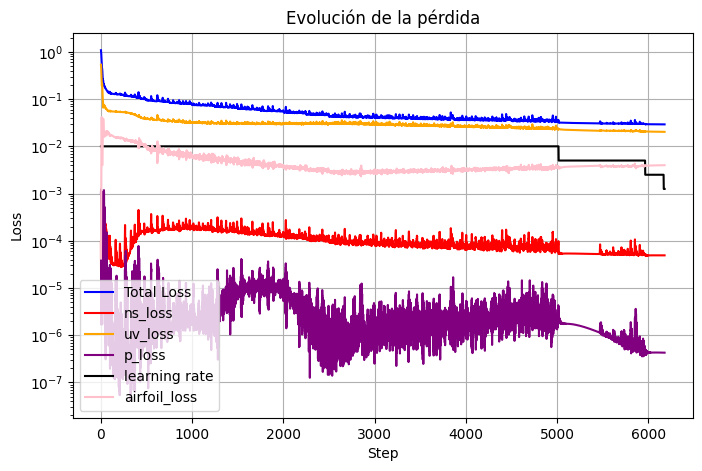

In [77]:
plt.figure(figsize=(8,5))
plt.semilogy(af_losses, label='Total Loss',color='blue')  # Usar semilogy para escala logarítmica en el eje y
plt.semilogy(af_ns_losses, label='ns_loss', color='red')
plt.semilogy(af_uv_losses, label='uv_loss', color='orange')
plt.semilogy(af_p_losses, label='p_loss', color='purple')
plt.semilogy(af_lr_list, label='learning rate', color='black')
plt.semilogy(airf_loss, label='airfoil_loss', color='pink')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Evolución de la pérdida")
plt.legend()
plt.grid(True)
plt.show()

LBFGS Model Training

In [78]:
X.requires_grad = True
inlet.requires_grad = True
outlet.requires_grad = True
bot_wall.requires_grad = True
top_wall.requires_grad = True

patience = 50
acc = 1e-3


def closure():
    af_optimizer.zero_grad()

    delta = af_model(X)
    V1, p = delta[:,0], delta[:,1]

    grads = Grads(V1, X)
    v, u = -grads[:,0], grads[:,1]

    grads = Grads(u, X)
    u_x, u_y = grads[:, 0], grads[:, 1]

    grads = Grads(v, X)
    v_x, v_y = grads[:, 0], grads[:, 1]

    grads = Grads(p, X)
    p_x, p_y = grads[:, 0], grads[:, 1]

    u_xx = Grads(u_x, X, 0)
    u_yy = Grads(u_y, X, 1)
    v_xx = Grads(v_x, X, 0)
    v_yy = Grads(v_y, X, 1)

    ns_loss = criterion(r0*(u*u_x + v*u_y) + p_x - din_vis*(u_xx + u_yy), torch.zeros_like(u, device=device)) +\
            criterion(r0*(u*v_x + v*v_y) + p_y - din_vis*(v_xx + v_yy), torch.zeros_like(u, device=device)) +\
            criterion(u_x + v_y, torch.zeros_like(u, device=device))
    

    # Boundary Conditions    
    # Inlet
    in_pred = af_model(inlet)
    grads = Grads(in_pred[:,0], inlet)
    in_v, in_u = -grads[:,0], grads[:,1]

    parab = 4/domain_size_y**2 * (domain_size_y - inlet[:,1]) * inlet[:,1]
    inlet_cond = torch.stack([
        Uinf * parab,
        torch.zeros_like(inlet[:,0], device=device),
    ], axis=-1)

    inlet_uv_loss = criterion(in_u, inlet_cond[:,0]) + criterion(in_v, inlet_cond[:,1])

    
    # Outlet
    out_pred = af_model(outlet)
    out_p = out_pred[:,1]

    outlet_p_loss = criterion(out_p, torch.zeros_like(out_p, device=device))
    

    # Bot boundary
    bot_pred = af_model(bot_wall)
    grads = Grads(bot_pred[:,0], bot_wall)
    bot_v, bot_u = -grads[:,0], grads[:,1]

    bot_bound_cond = torch.stack([
        torch.zeros_like(bot_wall[:,0], device=device),
        torch.zeros_like(bot_wall[:,0], device=device),
    ], axis=-1)

    bot_uv_loss = criterion(bot_u, bot_bound_cond[:,0]) + criterion(bot_v, bot_bound_cond[:,1])

    # Top boundary
    top_pred = af_model(top_wall)
    grads = Grads(top_pred[:,0], top_wall)
    top_v, top_u = -grads[:,0], grads[:,1]

    top_bound_cond = torch.stack([
        torch.zeros_like(top_wall[:,0], device=device),
        torch.zeros_like(top_wall[:,0], device=device),
    ], axis=-1)

    top_uv_loss = criterion(top_u, top_bound_cond[:,0]) + criterion(top_v, top_bound_cond[:,1])

    uv_loss = inlet_uv_loss + top_uv_loss + bot_uv_loss 
    p_loss = outlet_p_loss
    bound_loss = uv_loss + p_loss

    # Airfoil Conditions
    airfoil.requires_grad=True

    airfoil_pred = af_model(airfoil)
    dpsi = airfoil_pred[:,0]
    grads = Grads(dpsi, airfoil)
    af_v, af_u = -grads[:,0], grads[:,1]


    airfoil_cond = torch.stack([
        torch.zeros_like(airfoil[:,0], device=device),
        torch.zeros_like(airfoil[:,0], device=device),
    ], dim=-1)

    airfoil_loss = criterion(af_u, airfoil_cond[:,0]) + criterion(af_v, airfoil_cond[:,1])

    loss = (100*ns_loss + bound_loss + airfoil_loss)
    
    loss.backward()

    return loss
        
for lrate in [1]:
    best_loss = 1
    af_optimizer = torch.optim.LBFGS(
                af_model.parameters(),
                lr=lrate,
                max_iter=500,
                tolerance_grad=1e-5,
                tolerance_change=1e-9,
                history_size=100,
                line_search_fn='strong_wolfe'
                )
        
    for step in range(1, n_steps +1):
        loss_val = af_optimizer.step(closure)
        print(f"Step {step}, Loss = {loss_val.item():.6f}, learning_rate = {lrate:.3f}")

        
        if loss_val.item() < best_loss - acc:
            best_loss = loss_val.item()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

Step 1, Loss = 0.029144, learning_rate = 1.000
Step 2, Loss = 0.023737, learning_rate = 1.000
Step 3, Loss = 0.019998, learning_rate = 1.000
Step 4, Loss = 0.017359, learning_rate = 1.000
Step 5, Loss = 0.015485, learning_rate = 1.000
Step 6, Loss = 0.013654, learning_rate = 1.000
Step 7, Loss = 0.012222, learning_rate = 1.000
Step 8, Loss = 0.011135, learning_rate = 1.000
Step 9, Loss = 0.010440, learning_rate = 1.000
Step 10, Loss = 0.009767, learning_rate = 1.000
Step 11, Loss = 0.009265, learning_rate = 1.000
Step 12, Loss = 0.008784, learning_rate = 1.000
Step 13, Loss = 0.008382, learning_rate = 1.000
Step 14, Loss = 0.008043, learning_rate = 1.000
Step 15, Loss = 0.007769, learning_rate = 1.000
Step 16, Loss = 0.007500, learning_rate = 1.000
Step 17, Loss = 0.007184, learning_rate = 1.000
Step 18, Loss = 0.006844, learning_rate = 1.000
Step 19, Loss = 0.006462, learning_rate = 1.000
Step 20, Loss = 0.006122, learning_rate = 1.000
Step 21, Loss = 0.005823, learning_rate = 1.000
S

Model Prediction

In [83]:
u_pred, v_pred, p_pred, x, y = run_model(af_model, 500, domain_size_x, domain_size_y)
mesh = np.meshgrid(x, y)
mesh_points = len(x)

u_pred = u_pred.detach().cpu().numpy()
v_pred = v_pred.detach().cpu().numpy()
p_pred = p_pred.detach().cpu().numpy()

X, Y = np.meshgrid(x, y)  # (ny, nx)

# 2. Convertir el array 2D en una lista de puntos [(x0,y0), (x1,y1), ...]
points = np.vstack([X.ravel(), Y.ravel()]).T  # shape (N, 2)

# 3. Crear el Path del contorno del obstáculo (perfil/cilindro)
airfoil_path = Path(xy_train)  # frame debe ser (N, 2) con coordenadas (x,y)

# 4. Evaluar qué puntos están dentro del obstáculo
mask_flat = airfoil_path.contains_points(points)  # shape (N,)
mask = mask_flat.reshape(X.shape)  # volver al shape (ny, nx)

u_mean = np.mean(u_pred[~mask])
v_mean = np.mean(v_pred[~mask])
p_mean = np.mean(p_pred[~mask])

u_pred[mask] = u_mean
v_pred[mask] = v_mean
p_pred[mask] = p_mean

Prediction Results Plot

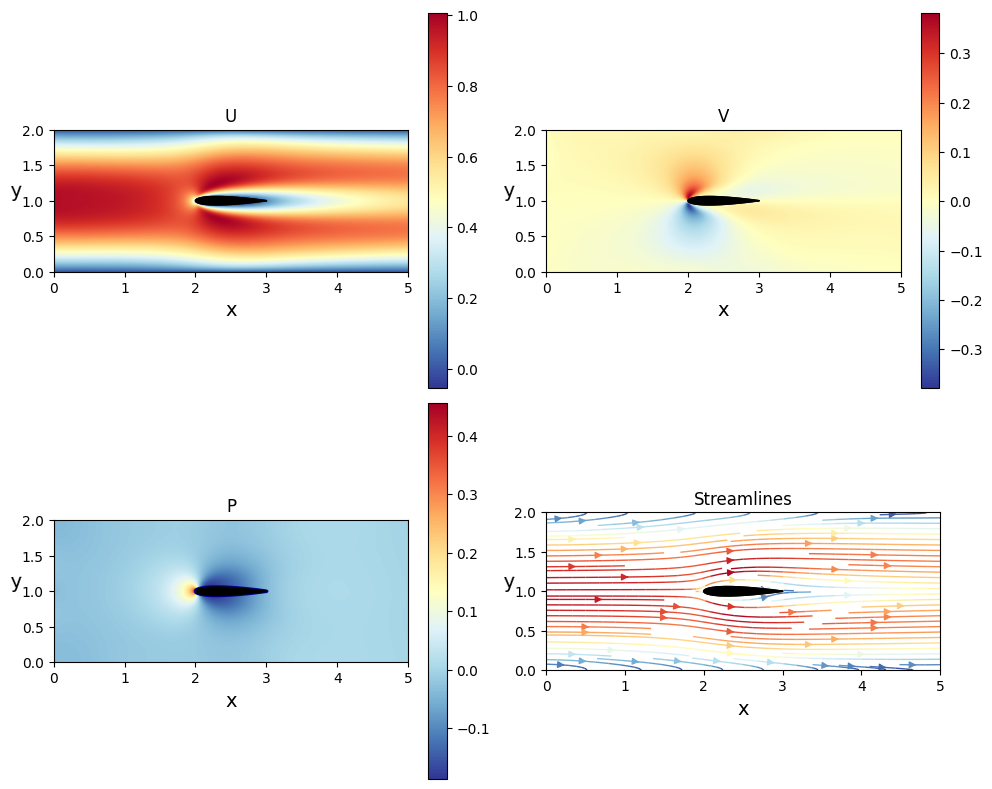

In [84]:
normals = compute_normals(xy_train)
offset_distance = 0.01
xy_offset = xy_train + normals * offset_distance

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))

im = ax1.imshow(u_pred[:,:], cmap='RdYlBu_r', vmin=u_pred.min(), vmax=u_pred.max(), origin='lower', 
                extent=[mesh[0].min(), mesh[0].max(), mesh[1].min(), mesh[1].max()])
fig.colorbar(im, ax=ax1, fraction=0.05)
ax1.plot(frame[:,0], frame[:,1], color='darkblue')
ax1.plot(xy_train[:,0], xy_train[:,1], color='black',linewidth=1)
ax1.set_xlabel("x", fontsize=14)
ax1.set_ylabel("y", fontsize=14, rotation=np.pi/2)
ax1.set_title("U")

im = ax2.imshow(v_pred[:,:], cmap='RdYlBu_r', vmin=v_pred.min(), vmax=v_pred.max(), origin='lower', 
                extent=[mesh[0].min(), mesh[0].max(), mesh[1].min(), mesh[1].max()])
fig.colorbar(im, ax=ax2, fraction=0.05)
ax2.plot(frame[:,0], frame[:,1], color='darkblue')
ax2.plot(xy_train[:,0], xy_train[:,1], color='black',linewidth=1)
ax2.set_xlabel("x", fontsize=14)
ax2.set_ylabel("y", fontsize=14, rotation=np.pi/2)
ax2.set_title("V")

im = ax3.imshow(p_pred[:,:], cmap='RdYlBu_r', origin='lower', 
                extent=[mesh[0].min(), mesh[0].max(), mesh[1].min(), mesh[1].max()])
fig.colorbar(im, ax=ax3, fraction=0.05)
ax3.plot(frame[:,0], frame[:,1], color='darkblue')
ax3.plot(xy_train[:,0], xy_train[:,1], color='black',linewidth=1)
ax3.plot(xy_offset[:,0], xy_offset[:,1], color='darkblue')
ax3.set_xlabel("x", fontsize=14)
ax3.set_ylabel("y", fontsize=14, rotation=np.pi/2)
ax3.set_title("P")

strm = ax4.streamplot(mesh[0], mesh[1], 
                      u_pred, 
                      v_pred, 
                      color=np.sqrt(u_pred**2 + v_pred**2),  # Mapa de color basado en la magnitud de la velocidad
                      cmap='RdYlBu_r', linewidth=1)
ax4.set_aspect('equal')
ax4.plot(xy_train[:,0], xy_train[:,1], color='black',linewidth=1)
ax4.plot(frame[:,0], frame[:,1], color='darkblue')
ax4.set_xlabel("x", fontsize=14)
ax4.set_ylabel("y", fontsize=14, rotation=np.pi/2)
ax4.set_title("Streamlines")

for ax in [ax1, ax2, ax3, ax4]:
    airfoil_patch = PathPatch(airfoil_path, facecolor='black', edgecolor='black', zorder=10)
    ax.add_patch(airfoil_patch)
    
plt.tight_layout()
plt.show()

Plot Predicted Cp Values

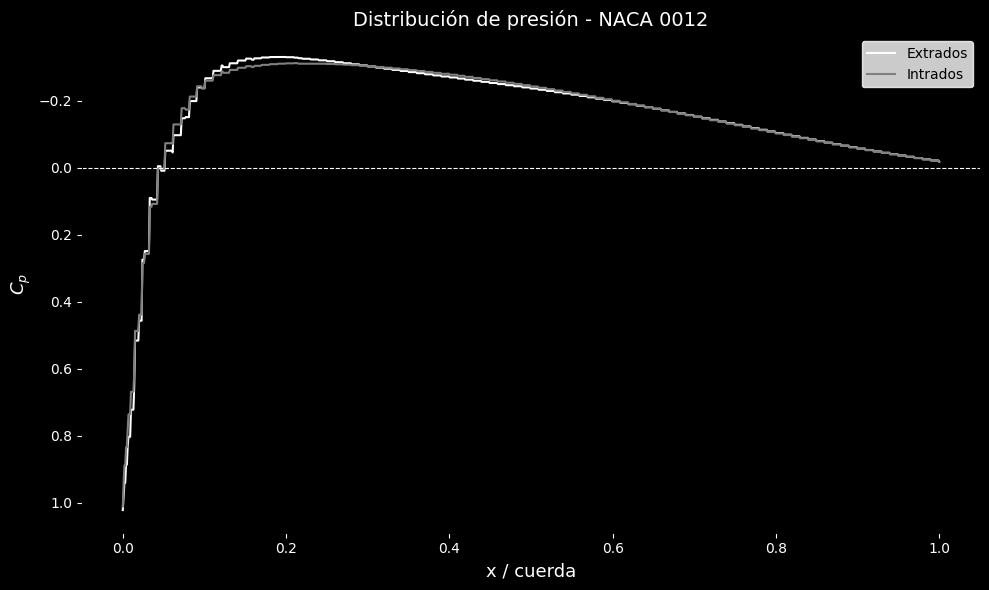

In [ ]:
new_mesh = points

tree = cKDTree(new_mesh)

inf = np.array([[0.1, domain_size_y / 2]])

# Ahora sí puedes buscar
_, indices = tree.query(xy_offset, k=1)
_, i_inf = tree.query(inf)

# Obtener presión en esos puntos
u_flat = u_pred.flatten(order='C')
v_flat = v_pred.flatten(order='C')
p_flat = p_pred.flatten(order='C')

p_perfil = p_flat[indices]

u_inf = u_flat[i_inf]
v_inf = v_flat[i_inf]
p_inf = p_flat[i_inf]

U_inf = np.sqrt(u_inf**2 + v_inf**2)

# Coeficiente de presión Cp = (p - p_inf) / (0.5 * rho * U_inf^2)
cp_perfil = (p_perfil - p_inf) / (0.5*r0*U_inf**2)
# cp_perfil = p_perfil

# Separar extrados e intrados
n_perfil = xy_train.shape[0]
cp_extrados = cp_perfil[:n_perfil//2]
cp_intrados = cp_perfil[n_perfil//2:]

xy_extrados = xy_train[:n_perfil//2]
xy_intrados = xy_train[n_perfil//2:]

x_extrados = ((xy_extrados[:, 0]) - leading_edge[0])/chord
x_intrados = ((xy_intrados[:, 0]) - leading_edge[0])/chord


# Graficar estilo XFOIL
plt.figure(figsize=(10, 6))
plt.plot(x_extrados, cp_extrados, color='white', label='Extrados')
plt.plot(x_intrados, cp_intrados, color='gray', label='Intrados')
plt.axhline(0, color='white', linestyle='--', linewidth=0.8)

plt.gca().invert_yaxis()
plt.grid(False)
plt.xlabel("x / cuerda", fontsize=13, color='white', font="serif")
plt.ylabel("$C_p$", fontsize=13, color='white', font="serif")
plt.title(f"Distribución de presión - NACA {naca}", fontsize=14, color='white', font="serif")
plt.legend(facecolor='white', edgecolor='white')
plt.gca().set_facecolor('black')
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.gcf().patch.set_facecolor('black')
plt.tick_params(colors='white')
plt.tight_layout()
plt.show()

Open and Run Xfoil for Reference Cp Values

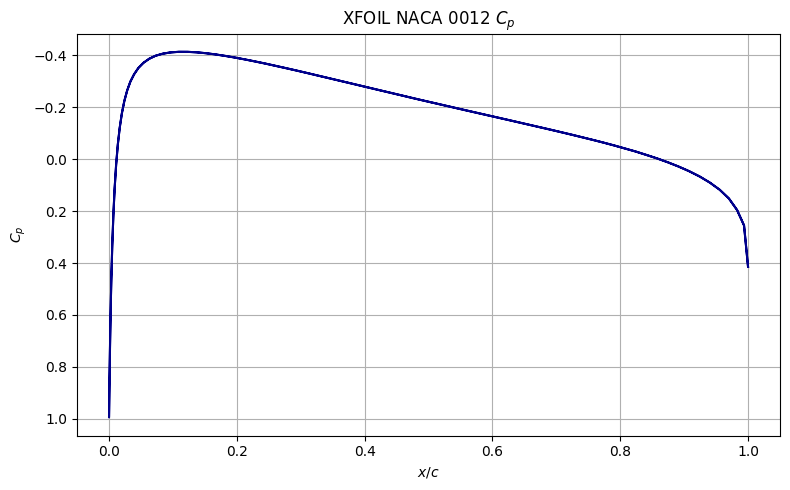

In [5]:
def run_xfoil(airfoil, alpha, Re, xfoil_path="xfoil"):
    """
    Ejecuta XFOIL y guarda los coeficientes de presión en cp.dat
    """
    commands = f"""
    NACA {airfoil[4:]} 
    OPER
    Re {Re:.0f}
    ALFA {alpha:.2f}
    CPWR cp.dat
    quit
    """
    
    # Ejecutar XFOIL
    process = subprocess.Popen(xfoil_path, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate(input=commands.encode())

    # Esperar a que se escriba el archivo
    time.sleep(1)

    if not os.path.exists("cp.dat"):
        raise RuntimeError("No se generó el archivo cp.dat. Revisa si XFOIL está bien instalado y en PATH.")

def read_cp(filename="cp.dat"):
    """
    Lee el archivo cp.dat generado por XFOIL.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()[3:]  # Saltar cabecera
        data = np.array([[float(val) for val in line.strip().split()] for line in lines])

    x = data[:, 0]  # Coordenada x/c
    y = data[:, 1] # Coeficiente de presión
    cp = data[:,2]
    return x, y, cp

foil = 'NACA'+naca
xfoil = "C:\\Users\\adria\\Desktop\\XFOIL6.99\\xfoil.exe"
run_xfoil(airfoil=foil, alpha=0.0, Re=Re, xfoil_path=xfoil)
x, y, cp = read_cp()

plt.figure(figsize=(8, 5))
plt.plot(x, cp, '-', color='darkblue')
plt.gca().invert_yaxis()
plt.xlabel("$x/c$")
plt.ylabel("$C_p$")
plt.title(f'XFOIL NACA {naca} $C_p$')
plt.grid(True)
plt.tight_layout()
plt.show()